# Trying to grid FIRE data for volumetric rendering

using Mike Grudic's meshoid code : https://github.com/mikegrudic/meshoid

I copied the .py files over here and also changed ".backend" to be simply "backend" in Meshoid.py.

In [1]:
%matplotlib inline

In [31]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from Meshoid import Meshoid
import h5py
import os
import numpy as np
import json
import pandas as pd

In [57]:
root = '/Users/ageller/VISUALIZATIONS/FIREdata/m12i_res7100/snapdir_600/'
files = [
    'snapshot_600.0.hdf5',
    'snapshot_600.1.hdf5',
    'snapshot_600.2.hdf5',
    'snapshot_600.3.hdf5'
]
rho = np.array([])
pdata = {}
fields = ["Masses", "Coordinates", "SmoothingLength", "Velocities"]

rhMin = 0 #density limit 
rhMax = 100 #for colormap in the test 2D plot
radLim = 600 #radius limit from center
res = 128 #resolution
precision = 4 #precision of the numbers printed to file
ptype = "PartType0"

In [58]:
# read in all the data
for i,f in enumerate(files):
    print(f)
    F = h5py.File(os.path.abspath(root + f),"r")
    rh = F[ptype]["Density"][:]*300. #I think this is the correct conversion
    rho = np.append(rho, rh)
    density_cut = (rh > rhMin)
    for field in fields:
        fi = F[ptype][field][:][density_cut]
        sh = fi.shape
        if (i == 0):
            pdata[field] = fi
        else:
            if (len(sh) > 1):
                pdata[field] = np.vstack((pdata[field], fi))
            else:
                pdata[field] = np.append(pdata[field], fi)
    F.close()

snapshot_600.0.hdf5
snapshot_600.1.hdf5
snapshot_600.2.hdf5
snapshot_600.3.hdf5


In [59]:
# recenter data and cut at desired radius
pos = pdata["Coordinates"]
center = np.median(pos,axis=0)
pos -= center
radius_cut = np.sum(pos*pos,axis=1) < radLim**2
pos = pos[radius_cut]
mass = pdata["Masses"][radius_cut] 
hsml = pdata["SmoothingLength"][radius_cut]
v = pdata["Velocities"][radius_cut]

C:\Users\ageller\AppData\Local\Temp\ipykernel_22228\1649223136.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolormesh(X, Y, dens, norm=colors.LogNorm(vmin=max(rhMin, 1e-8), vmax=rhMax))


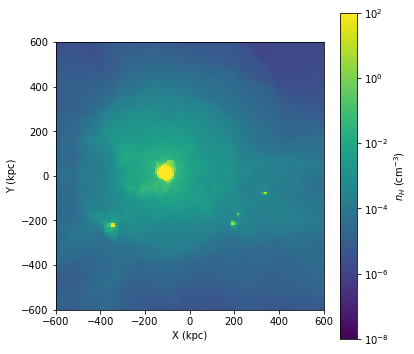

In [60]:
# plot the data
M = Meshoid(pos, mass, hsml)

X = Y = np.linspace(-radLim, radLim, res)
X, Y = np.meshgrid(X, Y)
dens = M.SurfaceDensity(M.Density(), center=np.array([0,0,0]), size=radLim, res=res)*300. #I think this is the right conversion

fig, ax = plt.subplots(figsize=(6,6))
p = ax.pcolormesh(X, Y, dens, norm=colors.LogNorm(vmin=max(rhMin, 1e-8), vmax=rhMax))

ax.set_aspect('equal')
fig.colorbar(p,label=r"$n_H$ $(\rm cm^{-3})$") 
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

In [61]:
# create a tree to interpolate on? (needed to InterpToGrid using method 'nearest')
M.TreeUpdate()

In [62]:
# interpolate to a grid (this is taking FOREVER using method='kernel'... seems a bit quicker using method='nearest')
grid = M.InterpToGrid(np.log10(M.Density()), res=res, method='nearest')

In [63]:
# rescale?
gridOut = grid.ravel()
gridOut = (gridOut - np.min(grid))/(np.max(grid) - np.min(grid))

In [64]:
# output to file that I can use for my rendering test
out = {'data':np.around(gridOut, precision).tolist(), 'size':[res,res,res]}
with open('FIREdata3D.json', 'w') as outfile:
    json.dump(out, outfile)

In [32]:
# # output to files that I can use for my rendering test
# pd.DataFrame({
#     'data':gridOut
# }).to_csv('FIREdata3D.csv', index=False)

In [33]:
# pd.DataFrame({
#     'xLength':[res],
#     'yLength':[res],
#     'zLength':[res]
# }).to_csv('FIREdata3Dsizes.csv', index=False)